# A tour of Machine Learning Clasifiers Using scikit-learn
En este capitulo se revisara una coleccion popular de algoritmos de machine learning. Interactuaremos por primera vez con la biblioteca **sickit-learn** y veremos algunos algoritmos de aprendizaje supervisado para clasificacion. 

### Como elegir un algortimo de clasificacion
Elegir un algoritmos de clasificacion para un problema en particular requiere practica y experiencia. Cada algoritmos tiene sus pros y sus contra asi como cada uno esta basado en diferentes hipotesis sobre los datos.

Los diferentes algoritmos pueden varias en cantidad e features necesarias, ruido en el dataset, si las clases a a clasificar son linealmente separables etc. En general, los principales pasos que estan involucrados en entrenar un algoritmo supervisado de ML son:

1. Seleccionar las features y recolectar ejemplos para el entrenamiento
2. Elegir una metrica de perfomance
3. Elegir un algoritmos y entrenar el modelo
4. Evaluar la perfomance del modelo
5. Cambiar la configuracion para mejorar el modelo

##  First steps with scikit-learn – training a perceptron

Vamos a hacer algo parecido a lo que hicimos el capitulo anterior y vamos entrenar un perceptron. Pero esta vez en lugar de armarlo desde 0 utilizando Numpy vamos a utilizar la biblioteca de scikit-learn.

In [15]:
from sklearn import datasets
import numpy as np
iris = datasets.load_iris()
X = iris.data[:,[2,3]]
y = iris.target
print('Class labels:', np.unique(y))

Class labels: [0 1 2]


In [16]:
#Para poder ver que tan bien funciona el modelo vamos a separar el dataset en train test,
#una metodolgia que se vera con mas profundidad en el capitulo 6

from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(
    X, y, test_size= 0.3, random_state= 1, stratify= y #Este parametro asegura la misma proporcion de labes en ambos datasets
)   

In [17]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


Muchos algoritmos de ML siguen ciertas hipotesis acerca de sus datos para poder funcionar de manera correcta, es este caso estandarizaremos los datos utilizando el **StandarScaler** de scikit lear.


In [18]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

Una vez estandarizados nuestros datos vamos a importar el perceptron y entrenarlo con nuestros datos. Por default muchos modelos de SK vienen con el tipo de clasificacion conocido como **one-versus-rest**

In [19]:
from sklearn.linear_model import Perceptron
ppn = Perceptron(eta0=0.01, random_state=1)
ppn.fit(X_train_sc,y_train)

Perceptron(eta0=0.01, random_state=1)

In [20]:
y_pred = ppn.predict(X_test_sc)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

Misclassified examples: 2


In [21]:
#Existen otras metricas que uno podria revisar de un modelo, como la accuracy.
from sklearn.metrics import accuracy_score
print("Accuracy: %.3f"% accuracy_score(y_test,y_pred))

Accuracy: 0.956


In [22]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions(X, y, classifier, test_idx=None,
                          resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
 # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')
 # highlight test examples
    if test_idx:
 # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='none', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='Test set')

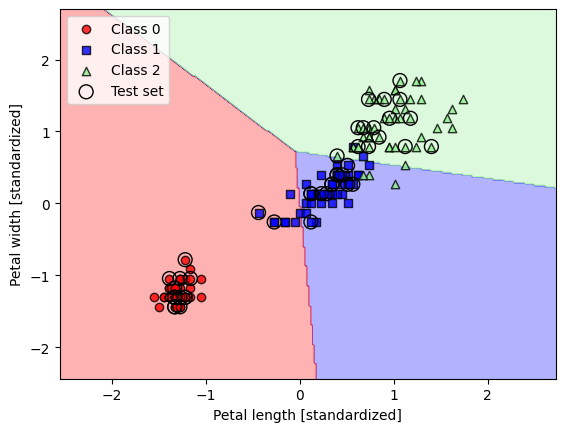

In [23]:
X_combined_std = np.vstack((X_train_sc, X_test_sc))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std,
                       y=y_combined,
                       classifier=ppn,
                       test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')


## Modeling class probabilites via logistic regression
Si bien la regla del percepron es un buen algoritmo introductorio para clasificacion. En realidad no es tan poderoso debido a que si las clases no son linealmente separables el algoritmo nunca va a converger.
En esta seccion veremos el algortimos de **regresion logistica** para clasificacion.

### Logistic regression and conditional probabilities.
Es un modelo de para clasificacin binaria. Funciona mediante el uso de **probabilidad condicional**.
Lo que buscamos es relacinar la funcion *logit* que esta definida como
$$
logit(p)= \frac{p}{(1-p)}
$$
de manera lineal con las features pesadas de la manera
$$
logit(p) = \sum_{i=j}w_{j}x_{j}+b
$$

Mientras que la funcion logit mapea las probabilidades a todo el rango de los numeros reales, nos gustaria tener la inversa. La cual mapea cualquiera numero real al rango de probabilidades entre [0,1]. La inversa es conocida como **funcion sigmoide**
$$
\sigma (z) = \frac{1}{z+e^{-z}}
$$
Donde $z$ es el input neto de la combinacion lineal de los pesos y los inputs.
$$
z = w^{T} x + b
$$

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\ivanl\AppData\Local\Temp\ipykernel_21012\108725810.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma (z)')


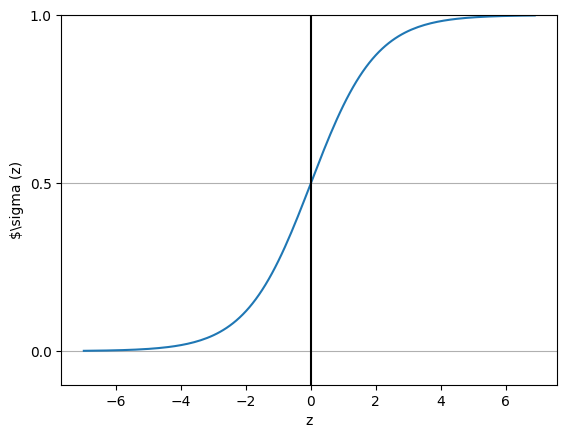

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))
z = np.arange(-7,7,0.1)
sigma_z = sigmoid(z)
plt.plot(z,sigma_z)
plt.axvline(0.0,color= 'k')
plt.ylim(-0.1,0.1)
plt.xlabel('z')
plt.ylabel('$\sigma (z)')
plt.yticks([0.0,0.5,1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout
plt.show()

El ouput de la sigmoide se interpreta como la probabilidad de un ejemplo en particular de pertencer a una cierta clase, es decir
$$
\sigma (z) = p(y = 1|x;w;b)
$$
luego utiliznado la funcion de corte se convierte esta probabilidad en un output binario.


### Learning the model weigths via the logistic loss function
Al igual que vimos anteriormente la funcion de perdida MSE, queremos definir una funcion de perdida para la regresion logistica la cual optimizar para obtener los parametros $w$ y $b$ ideales. En el caso de la regresion logistica vamos a buscar **maximizar la likelihood**. La cual, en el caso de que todos los ejemplos en el dataset sean independientes entre si, se escribe como:
$$
L(w,b|x) = p(y|x;w,b) = \prod_{i}^{n} p(y^{i}|x^{i};w,b) = \prod (\sigma (z^{i}))^{y^{i}} (1-\sigma (z^{i}))^{1-y^{i}}
$$
En su lugar vamos a maximizar el logartimos de esta ecuacion ,ya que es mas sencillo
$$
l(w,b|x) = log(L) = \sum_{i} v
$$
Esta funcion es una que se debe **maximiza** pero es posible reescribiarla de forma que sea minimizable y aplicarle el descenso de gradiente como venimos haciendo.
$$
L(w,b) = \sum_{i}^{n} [- y^{i}\log (\sigma (z^{i}))- (1-y^{i}) \log (1- \sigma (z^{i}))]
$$
Esto puede verse como dos fuciones distintas, que forman una.

<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
C:\Users\ivanl\AppData\Local\Temp\ipykernel_21012\2806226088.py:14: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma(z)$')


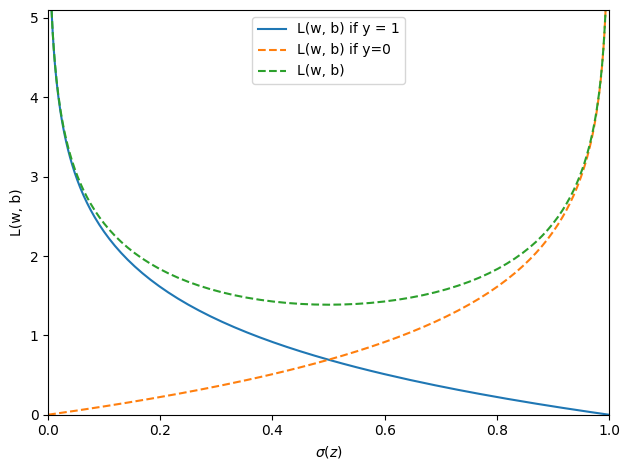

In [25]:
def loss_1(z):
    return - np.log(sigmoid(z))
def loss_0(z):
    return - np.log(1-sigmoid(z))
z = np.arange(-10, 10, 0.1)
sigma_z = sigmoid(z)
c1 = [loss_1(x) for x in z]
plt.plot(sigma_z, c1, label= 'L(w, b) if y = 1')
c0 = [loss_0(x) for x in z]
plt.plot(sigma_z, c0, linestyle='--', label='L(w, b) if y=0')
plt.plot(sigma_z, np.array(c1) + np.array(c0) , linestyle='--', label='L(w, b)')
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\sigma(z)$')
plt.ylabel('L(w, b)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Converting an Adaline implementation into an algorithm for logistic regression.
La implementacion  es sencilla, ya que la base del del algoritmos es le mismo, donde lo que se cambia es la funcion de perdida a utilizar.

In [26]:
class LogisticRegressionGD:
    """Gradient descent-based logistic regression classifier.

    Parameters
    -----------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int
        Random number generator seed for random weight
        initialization.

    Attributes
    ----------
    w_ : 1d-array
        Weights after training
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
        Mean squared error loss function values in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
            self.eta = eta
            self.n_iter = n_iter
            self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.
        Parameters
        ---------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the 
          number of examples and n_features is the 
          number of features.
        y : array-like, shape = [n_examples]
          Target values.
        Returns
        ------
        self : Instance of LogisticRegressionGD
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)
        self.losses_ = []
        for i in range(self.n_iter):
                    net_input = self.net_input(X)
                    output = self.activation(net_input)
                    errors = (y - output)
                    self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
                    self.b_ += self.eta * 2.0 * errors.mean()
                    loss = (-y.dot(np.log(output))
                        - ((1
        - y).dot(np.log(1 - output)))
                            / X.shape[0])
                    self.losses_.append(loss)
        return self
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_
    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)  



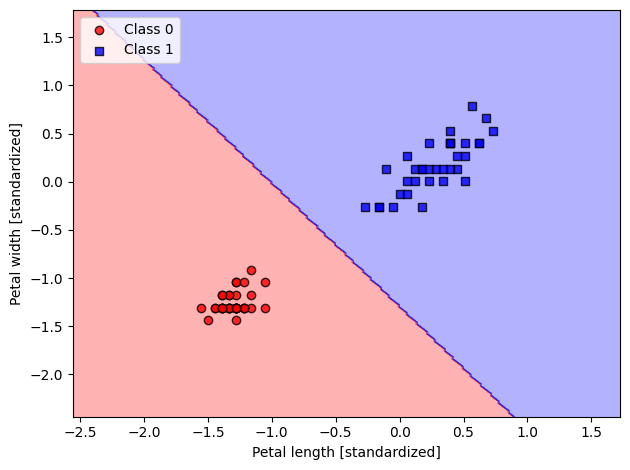

In [27]:
#este modelo solo sirve para clasifiacion binaria
X_train_01_subset = X_train_sc[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]
lrgd = LogisticRegressionGD(eta=0.3,
                             n_iter=1000,
                              random_state=1)
lrgd.fit(X_train_01_subset,
           y_train_01_subset)
plot_decision_regions(X=X_train_01_subset,
                        y=y_train_01_subset,
                        classifier=lrgd)
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Training a logistic regression model with scikit-lear
Lo que hicimos recien fue una implementacion manual del algoritmos, pero scikit-learn cunta con una implemetnacion mucho mas sofisticada del algoritmos con la posibilidad ademas de soportar clasificacion multiclase

c:\Users\ivanl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


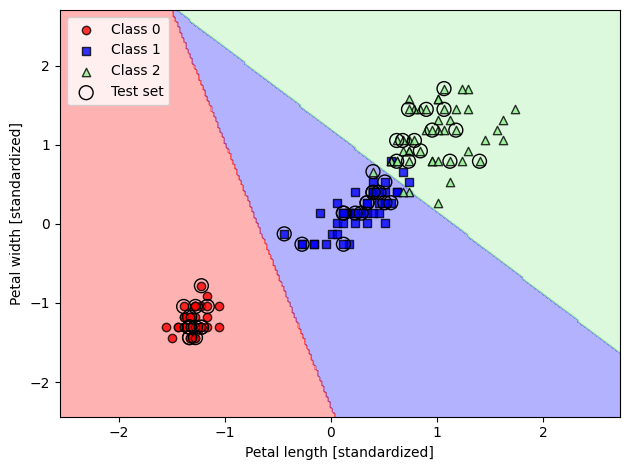

In [28]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.0, solver='lbfgs', multi_class='ovr')
lr.fit(X_train_sc,y_train)
plot_decision_regions(X_combined_std,y_combined,classifier=lr,test_idx=range(105,150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Tackling overfitting via regularization

El overfitting es un problema muy comun en machine learning, donde el algortimo es incapaz de generalizar a nuevos datos debido a que ajusta **demasiado bien** al os datos de prueba, por lo que tiene alta varianza


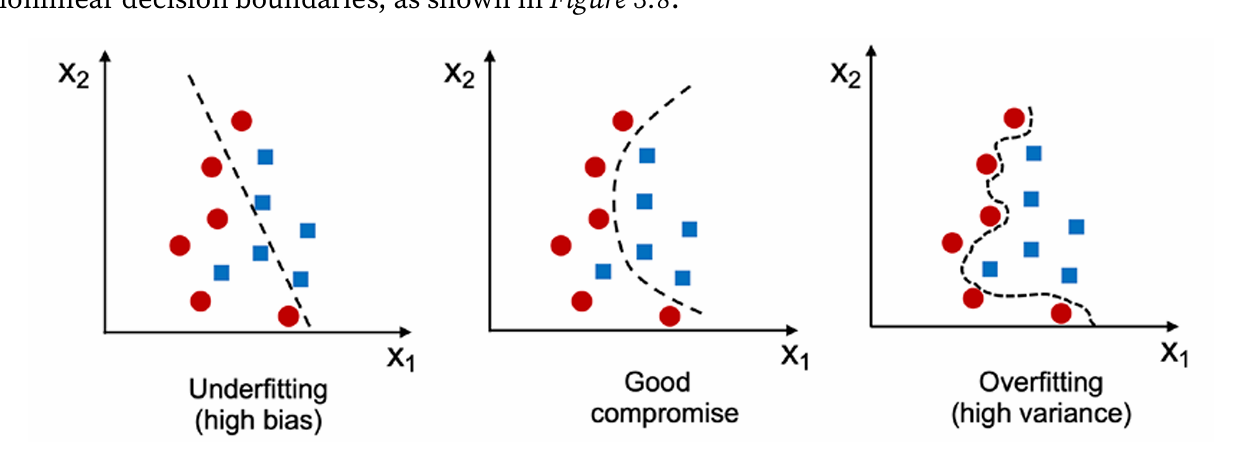

Una manera de locuhar contra el overfitting es introducir el concepto de **regularizacion**, donde se busca penalizar los valores grandes de parametros. La forma mas comun de regularizacion es la conocida como **L2** que se escibre como

$$
\frac{\lambda}{2n}||w||^{2} = \frac{\lambda}{2n} \sum_{j=1}^{m}w_{j}^{2}
$$
donde $\lambda$ es el **parametro de regularizacion**

## Maximum margin classificaction with support vector machines
Otro algoritmos muy poderozo y conocido es el de **suuport vector machine (SVM)**, el se puede pensar como una extension del percetron. En el perceptron se busca minimizar los errores de clasificacion. Pero, en las SVM, lo qu se busca es maximizar el margen.

El margen se define como la distancia entre los  hiperplanos separadores (fronteras de desicion) y los ejemplos de entrenamientos que esten mas cerca del hiperplano (Estos serian los **vectores de soporte**)

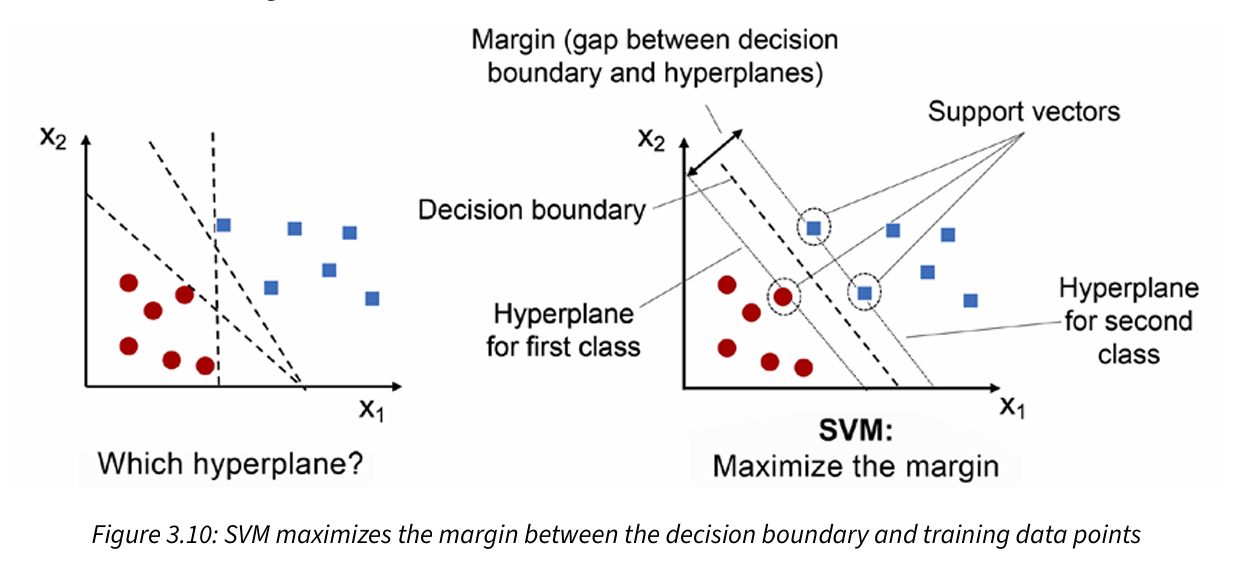

### Maximun margin intuition
La razon detras de tener fronteras de decision con margenes largos es que tienen menos error de generalizcion, y modelos con marngenes chicos tienden al overfitting. 
La matematica detras de SVM es un tanto avanzada, para poder adentrarse en la misma se recomeinda:
- Introduccion to statistical learning, capiutlo 9

### Dealing with nonliearnly separable case using slack variables
El concepto de slack variables se introduce para poder relajar las condiciones lineales de optimizacion que posee la SVM para poder manejar clases linealmente no separables y asi permitir la convergancia, ese parametro cumple el mismo rol que en las seccion de **regularizacion**. Donde en lugar de penalizar valores altos de parametros, se busca penalizar clasificaciones errorenas.

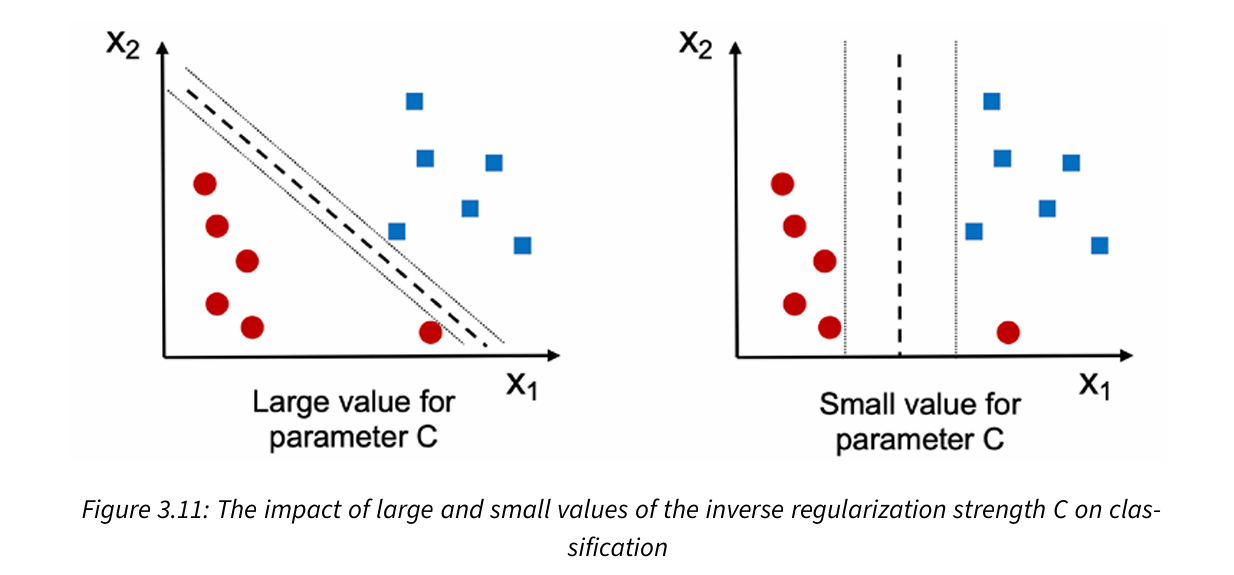

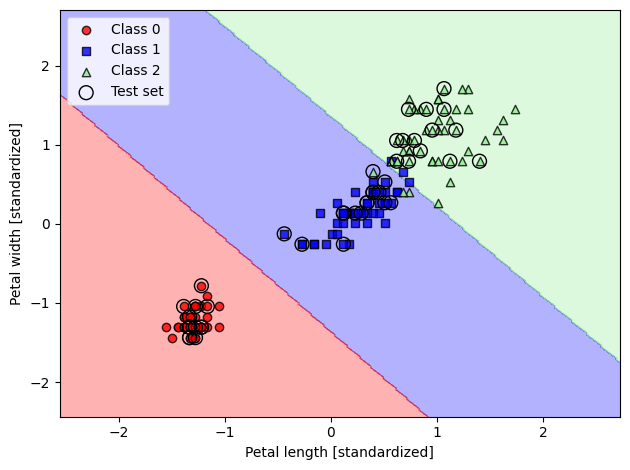

In [29]:
from sklearn.svm import SVC
svm = SVC(kernel='linear',C=1.0,random_state=1)
svm.fit(X_train_sc,y_train)
plot_decision_regions(X_combined_std,y_combined,classifier=svm,test_idx=range(105,150))

plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
                      

#### Logistic regression versus SVMs
El cuando elegir una u otra dependera del contexto, en general la regresion logistica es mas sensible a outliners debido a que lo que busca es maximizar la likelioods. Pero a su vez es un modelo mas sencillo y es mas interpretable que un SVM.

## Solving nonlinear problems using a kernel SVM
Una razon por la cual las SVM son tan populares es porque pueden ser **kernelizadas** para resolver poblemas de clasificacion no lineales. Veamos primero como se veria un problema no lineal de clasificacion

### Kernel methods for linearly inseparable data
Con el siguiente codigo crearemos un dataset con la forma de una XOR gate.

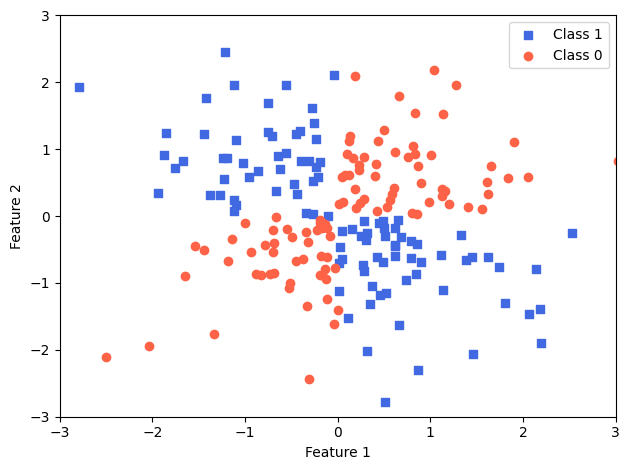

In [32]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
 
                        X_xor[:, 
1] > 0)
y_xor = np.where(y_xor, 1, 0)
plt.scatter(X_xor[y_xor == 1, 0],
 
 
 
             X_xor[y_xor == 1, 1],
             c='royalblue', marker='s',
             label='Class 1')
plt.scatter(X_xor[y_xor == 0, 0],
 
             X_xor[y_xor == 0, 1],
 
 
             c='tomato', marker='o',
             label='Class 0')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Evidentente no podremos seprar esto con una frontera de desicion _lineal_, la idea de los metodos kernal para poder trabajar con este tipo de clases es crear una combinacion no linear de las features original y proyectarlas en una dimension mayor mediante una **funcion de mapeo $\phi$** en la cual los datos se vuelven linealmente separables. Por ejemplo con la siguiente funcion
$$
\phi (x_{1},x_{2}) = (z_{1},z_{2},z_{3}) = (x_{1},x_{2},x_{1}^{2}+x_{2}^{2})
$$

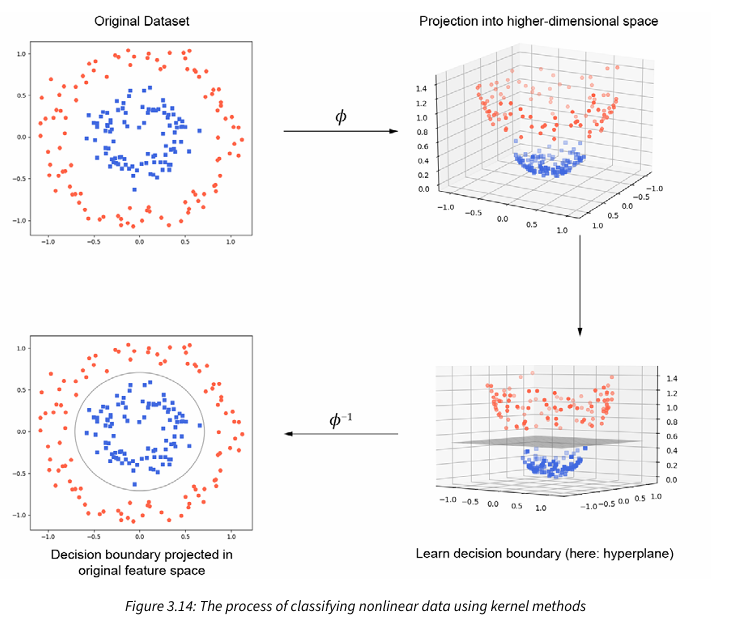



### Using the kernel trick to find separating hyperplanes in a high-dimensional space
El problema del truco que vimos anteriormente es que computacionalmente es muy costoso, sobretodo si estamos lidiando con data altamente dimensional. Por lo que se introduce en **kernel trick**

Este truco basicamente lo que hace es remplazar el calculo explicito del producto interno entre $x^{(i)T}x^{(j)}$ por $\phi (x^{(i)})^{T} \phi (x^{(j)})$. Esto se hace definiendo una **funcional de kernel**:
$$
\kappa (x^{i},x^{j}) = \phi (x^{(i)})^{T} \phi (x^{(j)})
$$

La eleccion mas comun es la conocida como **radial basis function (RBF)** o **Kernel gaussiano**:
$$
\kappa (x^{i},x^{j}) = \exp (\frac{-||x^{i}-x^{j}||^{2}}{2\sigma^{2}})
$$

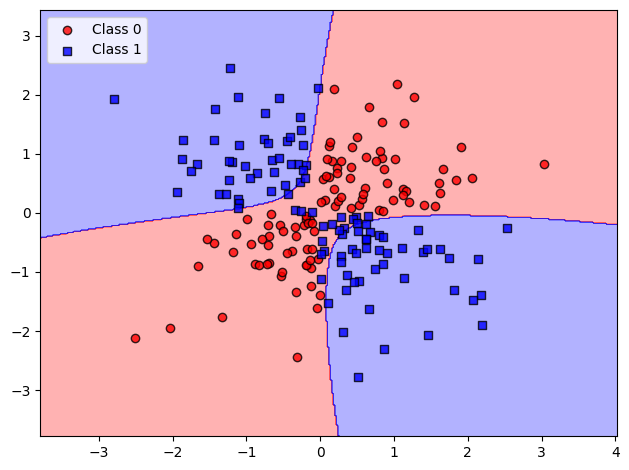

In [33]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()